In [1]:
import numpy as np
import numpy.matlib
import math
import random
import os
import tensorflow as tf
import pickle
import numpy.matlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from utils import *
%matplotlib inline

In [2]:
# declare parameters
# all characters the model currently support
alphabet = ' abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'
#total recognizable vocabulary size + 1 for unknown characters
v_len = len(alphabet) + 1
# input text to synthesize
text = 'hello world'
text_length = len(text)
# number of cells for a single layer
# currently only support uniform cell layout
rnn_size = 100
# RNN timestep 
tsteps = 1
batch_size = 1
#tensor shape
placeholder_shape = [None, tsteps, 3]
#soft-window parameter
kmixtures = 1
#MDN parameter
nmixtures = 8
# misc
save_path = './saved'
data_dir = './data'
bias = 1.0
# threshold for ending a stroke
eos_prob = 0.4
#number of total layers, at least 2, the model pretrained has 3 layers
num_layers = 3

In [3]:
# initial weight vector proposed in Alex_Graves Paper
LSTM_initializer = tf.truncated_normal_initializer(mean=0., stddev=.075, seed=None, dtype=tf.float32)

window_b_initializer = tf.truncated_normal_initializer(mean=-3.0, stddev=.25, seed=None, dtype=tf.float32)

#initialize cells for multiple layers(at least 2)
cell = [None] * num_layers

for i in range(num_layers) :
    cell[i] = tf.contrib.rnn.LSTMCell(rnn_size, state_is_tuple=True, initializer=LSTM_initializer)


In [4]:
# tf placeholder
input_data = tf.placeholder(dtype=tf.float32, shape=placeholder_shape)
output_data = tf.placeholder(dtype=tf.float32, shape=placeholder_shape)

#corresponding tensors
#i : initial state
#f : final state
#o : layer output
istate_cell = [None] *num_layers
outs_cell = [None] * num_layers
fstate_cell = [None] * num_layers

for i in range(num_layers) :
    istate_cell[i] = cell[i].zero_state(batch_size=batch_size, dtype=tf.float32)
    
inputs = [tf.squeeze(i, [1]) for i in tf.split(input_data, tsteps, 1)]

#build first layer
outs_cell[0], fstate_cell[0] = tf.contrib.legacy_seq2seq.rnn_decoder(inputs, istate_cell[0], cell[0], loop_function=None, scope='cell0')

In [5]:
#attention mechanism
def get_phi(length, a, b, k):
    u = np.linspace(0, length-1 , length) 
    e = tf.multiply(b, - tf.square(tf.subtract(k,u)))
    phi = tf.multiply(a, tf.exp(e))
    return tf.reduce_sum(phi, 1, keep_dims=True)

# get the soft window 
def get_window(coef):
    [a, b, k, c] = coef
    length = c.get_shape()[1].value #number of items in sequence
    phi = get_phi(length, a, b, k)
    window = tf.squeeze(tf.matmul(phi,c), [1])
    return window, phi

# soft window parameters 
def get_coef(i, out_cell, kmixtures, prev_k, char_seq, reuse=True):
    hidden = out_cell.get_shape()[1]
    n_out = 3*kmixtures
    with tf.variable_scope('window',reuse=reuse):
        window_w = tf.get_variable("window_w", [hidden, n_out], initializer=LSTM_initializer)
        window_b = tf.get_variable("window_b", [n_out], initializer=window_b_initializer)
    co = tf.nn.xw_plus_b(out_cell, window_w, window_b) 
    abk = tf.exp(tf.reshape(co, [-1, 3*kmixtures,1]))
    a, b, k = tf.split(abk, 3, 1) 
    k = k + prev_k
    return a, b, k, char_seq


In [6]:
# MDN above the last LSTM layer
def gaussian2d(x1, x2, m1, m2, s1, s2, r):
    # define gaussian mdn (eq 24, 25 from http://arxiv.org/abs/1308.0850)
    (sub1, sub2) = (tf.subtract(x1, m1), tf.subtract(x2, m2))
    sum_1 = tf.square(tf.div(sub1, s1)) + tf.square(tf.div(sub2, s2))    
    Z = sum_1 - 2*tf.div(tf.multiply(rho, tf.multiply(sub1, sub2)), tf.multiply(s1, s2))
    reg = 2*np.pi*tf.multiply(tf.multiply(s1, s2), tf.sqrt(1 - tf.square(r)))
    gaussian = tf.div(tf.exp(tf.div(-Z,2* (1 - tf.square(r)))), reg)
    return gaussian

#coefficient for MDN layer, detail function can be found in related papers
def get_mdn_coef(Z):
    global pi_hat, m1_hat, m2_hat, s1_hat, s2_hat, r_hat
    pi_hat, m1_hat, m2_hat, s1_hat, s2_hat, r_hat = tf.split(Z[:, 1:], 6, 1)
    eos = tf.sigmoid(-1*Z[:, 0:1])
    pi = tf.nn.softmax(pi_hat) # softmax
    m1 = m1_hat; m2 = m2_hat # leave mu1, mu2 as they are
    s1 = tf.exp(s1_hat); s2 = tf.exp(s2_hat) # exp for sigmas
    r = tf.tanh(r_hat) # tanh for rho (squish between -1 and 1)

    return [[eos, pi, m1_hat, m2_hat, tf.exp(s1_hat), tf.exp(s2_hat), tf.tanh(r_hat)], [pi_hat, m1_hat, m2_hat, s1_hat, s2_hat, r_hat]]

def sample_gaussian2d(m1, m2, s1, s2, rho):
    sample = np.random.multivariate_normal([m1, m2], [[s1*s1, rho*s1*s2], [rho*s1*s2, s2*s2]], 1)
    return sample[0][0], sample[0][1]

In [7]:
#initial parameters
init_kappa = tf.placeholder(dtype=tf.float32, shape=[None, kmixtures, 1]) 
char_seq = tf.placeholder(dtype=tf.float32, shape=[None, text_length, v_len])
wavg_prev_kappa = init_kappa
prev_window = char_seq[:,0,:]

#add soft window to the top of the first LSTM layer 
reuse = False
for i in range(len(outs_cell[0])):
    coef = get_coef(i, outs_cell[0][i], kmixtures, wavg_prev_kappa, char_seq,  reuse=reuse)
    (_, _, next_kappa, _) = coef
    window, phi = get_window(coef)
    #combine first layer output, soft-window, and original input text
    outs_cell[0][i] = tf.concat((outs_cell[0][i], window, inputs[i]), 1)
    wavg_prev_kappa = tf.reduce_mean(next_kappa, reduction_indices=1, keep_dims=True) # mean along kmixtures dimension
    reuse = True

(alpha, beta, next_kappa, _) = coef

In [8]:
#connect rest of the LSTM layers
for i in range(1, num_layers):
    scope = 'cell' + str(i)
    outs_cell[i], fstate_cell[i]= tf.contrib.legacy_seq2seq.rnn_decoder(outs_cell[i-1], istate_cell[i], cell[i], \
                                                    loop_function=None, scope=scope) #use scope from training

#final model output 
r_out = tf.reshape(tf.concat(outs_cell[num_layers - 1], 1), [-1, rnn_size])

In [9]:
#add connection layer for MDN 
n_out = 1 + nmixtures * 6 # params = end_of_stroke + 6 parameters per Gaussian
with tf.variable_scope('mdn_dense'):
    output_w = tf.get_variable("output_w", [rnn_size, n_out], initializer=LSTM_initializer)
    output_b = tf.get_variable("output_b", [n_out], initializer=LSTM_initializer)

output = tf.nn.xw_plus_b(r_out, output_w, output_b)

In [10]:
[x1_data, x2_data, eos_data] = tf.split(tf.reshape(output_data,[-1, 3]), 3, 1) #we might as well split these now
retval = get_mdn_coef(output)
[eos, pi, mu1, mu2, sigma1, sigma2, rho] = retval[0]
[pi_hat, mu1_hat, mu2_hat, sigma1_hat, sigma2_hat, rho_hat] = retval[1]

In [11]:
#initialize sessions and load pre-trained model
sess = tf.InteractiveSession()
saver = tf.train.Saver(tf.global_variables())
sess.run(tf.global_variables_initializer())
ckpt = tf.train.get_checkpoint_state(save_path)
model = ckpt.model_checkpoint_path
saver.restore(sess, model)
print("model:" + model)

model:./saved/model.ckpt-124500


In [12]:
#parameters for sampling process
one_hot = [to_one_hot(text, text_length, alphabet)]  # convert input string to one-hot vector
c = [None] * num_layers
h = [None] * num_layers
for i in range(num_layers):
    c[i] = istate_cell[i].c.eval()
    h[i] = istate_cell[i].h.eval()
# attention mechanism start
kappa = np.zeros((1, kmixtures, 1))
#first stroke
prev_x = np.asarray([[[0, 0, 1]]], dtype=np.float32)

In [13]:
finished = False ; i = 0
kappa_new = kappa
strokes = []
while not finished and i < 800:
    # data feed into the network allocated above
    feed = {input_data: prev_x, char_seq: one_hot,init_kappa: kappa_new,} 
    fetch = [pi_hat, mu1, mu2, sigma1_hat, sigma2_hat, rho, eos, \
             window, phi, next_kappa, wavg_prev_kappa, alpha]
    
    for i in range(num_layers):
        feed[istate_cell[i].c] = c[i]
        feed[istate_cell[i].h] = h[i]
        fetch.append(fstate_cell[i].c)
    
    for i in range(num_layers):
        fetch.append(fstate_cell[i].h)

    output = sess.run(fetch, feed)
    
    [pi_hat_new, mu1_new, mu2_new, sigma1_hat_new, sigma2_hat_new, rho_new, eos_new, window_new, phi_new, kappa_new\
     , wavg_kappa_new, alpha_new] = output[0:12]
    
    c = output[12:12 + num_layers]
    
    h = output[12 + num_layers:]

    #adding bias
    sigma1 = np.exp(sigma1_hat_new - bias)
    sigma2 = np.exp(sigma2_hat_new - bias)
    pi_hat_new *= 1 + bias # apply bias
    pi = np.zeros_like(pi_hat_new) # need to preallocate 
    pi[0] = np.exp(pi_hat_new[0]) / np.sum(np.exp(pi_hat_new[0]), axis=0) #apply a soft-max
    
    # choose a component from the MDN
    index = np.random.choice(pi.shape[1], p=pi[0])
    
    #detemine if to start a new stroke
    if eos_prob > eos_new[0][0] :
        eos_new = 0
    else :
        eos_new = 1

    point = sample_gaussian2d(mu1_new[0][index], mu2_new[0][index], sigma1[0][index], sigma2[0][index], rho_new[0][index])
        
    strokes.append([mu1_new[0][index], mu2_new[0][index], sigma1[0][index], sigma2[0][index], rho_new[0][index], eos_new])
    
    # check if the sequence generation has finished
    if kappa_new[0][np.where(alpha_new[0]==np.max(alpha_new[0]))] > len(text): 
        finished = True
                                                                        
    # put the output back into the network
    prev_x[0][0] = np.array(point + (eos_new, ), dtype=np.float32)
    kappa_new = wavg_kappa_new
    i+=1

strokes = np.vstack(strokes)

# the network predicts the displacements between pen points, so do a running sum over the time dimension
strokes[:,:2] = np.cumsum(strokes[:,:2], axis=0)

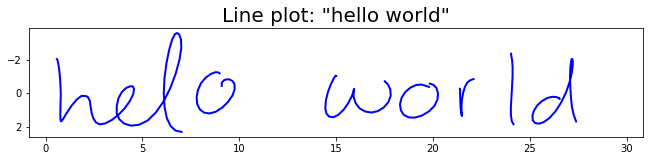

In [14]:
# plots the final result, from scribe
def line_plot(strokes, title, figsize = (20,2)):
    plt.figure(figsize=figsize)
    eos_preds = np.where(strokes[:,-1] == 1)
    eos_preds = [0] + list(eos_preds[0]) + [-1] #add start and end indices
    for i in range(len(eos_preds)- 1):
        start = eos_preds[i]+1
        stop = eos_preds[i+1]
        plt.plot(strokes[start:stop,0], strokes[start:stop,1],'b-', linewidth=2.0) #draw a stroke
    plt.title(title,  fontsize=20)
    plt.gca().invert_yaxis()
    plt.show()
    
line_plot(strokes, 'Line plot: "{}"'.format(text), figsize=(text_length,2))